## Deep Q-Learning implementation based on [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

In [1]:
import sys

sys.path.append("../src/")

%load_ext autoreload
%autoreload 2

In [2]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print(f"Using device: {device}")

Using device: mps


In [3]:
# Import necessary libraries
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable
import seaborn as sns
import shutil

import matplotlib.pyplot as plt

import cv2
import imageio

from utils import create_env, show
from base_agent import BaseAgent
from replay_memory import ReplayMemory, Transition
from summary_writer import LocalSummaryWriter


In [4]:
"""Deep Q Learning Network."""

class DQN(nn.Module):
    """Deep Q Network."""

    def __init__(self, in_size, out_size, num_hidden=128):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(in_size, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, out_size)

    def forward(self, x):
        """Forward pass through the network."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [11]:
class DQNAgent(BaseAgent):
    """DQN Agent that interacts with and learns from the environment."""

    # local_qnetwork--> selects the action
    # target_qnetwork --> calculate target queue values in the local network
    # double queue network stablizes the learning process
    def __init__(
        self,
        env: gym.Env,
        dqn: nn.Module,
        loss: Tensor,
        lr=0.001,
        eps_start=1.0,
        eps_end=0.1,
        eps_decay=0.995,
        batch_size=100,
        target_update=4,
        gamma=0.999,
        writer: LocalSummaryWriter = None,
    ):
        self.writer = writer
        self.logs = writer.log_dir
        self.env = env
        self.policy_net = dqn
        self.target_net = dqn

        # Set Target network parameters to be the same as the local network
        # This is done to stabilize the learning process
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.loss = loss
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.target_update = target_update
        self.gamma = gamma
        self.steps = 0

        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}

    def act(self, state: any, eps_thresh: float) -> Tensor:
        """Select new action based on the current state."""
        # epsilon greedy action selection
        # with probability eps_thresh select random action
        # otherwise select the action with the highest expected return
        sample = random.random()

        if sample > eps_thresh:
            with torch.no_grad():
                # select the optimal action based on the maximum expected return
                action = torch.argmax(self.policy_net(state)).view(1, 1)
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return action
        else:
            # Random action
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize(self) -> float:
        """Opitimize policy network via batch learning."""
        # If the memory is not full, we cannot sample a batch
        if len(self.memory) < self.batch_size:
            return 1.0

        sample_transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*sample_transitions, strict=False))

        # get a list that is True where the next state is not "done"
        has_next_state = torch.tensor(
            list(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool
        )
        next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        pred_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.

        next_state_values = torch.zeros(self.batch_size, device=device)
        # get the max along each row using the target network, then detach
        with torch.no_grad():
            # select the maximum Q value for each next state
            # and detach the result to avoid backpropagation through the target network
            next_state_values[has_next_state] = self.target_net(next_states).max(1)[0].detach()

        # Q(s, a) = reward(s, a) + Q(s_t+1, a_t+1)* gamma
        target_values = (next_state_values * self.gamma) + reward_batch

        # Compute loss
        loss = self.loss(pred_values, target_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.cpu().detach().numpy()

    def step(self, action: int) -> tuple[Tensor, Tensor, bool, bool]:
        """Take a step in the environment."""
        state, reward, done, terminated, _ = self.env.step(action)
        return (
            torch.FloatTensor([state]).to(device),
            torch.FloatTensor([reward]).to(device),
            done,
            terminated,
        )

    def train(self, episodes=100, smooth=100):
        """Training loop."""
        steps = 0
        smoothed_reward = []
        mean_reward = 0
        eps_thresh = self.eps_start
        for episode in range(episodes):
            c_loss = 0
            c_samples = 0
            rewards = 0
            done = False
            truncated = False

            state, _ = self.env.reset()
            state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)

            while not done or truncated:
                # get a decayed epsilon threshold
                eps_thresh = max(
                    self.eps_end,
                    eps_thresh - (self.eps_start - self.eps_end) * self.eps_decay,
                )
                action = self.act(state, eps_thresh)
                observation, reward, done, truncated = self.step(action.item())

                if done or truncated:
                    next_state = None
                else:
                    next_state = observation

                self.memory.push(state, action, next_state, reward)
                state = next_state

                loss = self.optimize()

                if steps % self.target_update == 0:
                    # update of the target network's weights
                    self.target_net.load_state_dict(self.policy_net.state_dict())

                rewards += reward.detach().item()
                steps += 1
                c_samples += self.batch_size
                c_loss += loss

                if done or truncated:
                    break

            smoothed_reward.append(rewards)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.writer.add_scalar("Loss", c_loss / c_samples, episode)
            self.writer.add_scalar("Epsilon", eps_thresh, episode)
            self.writer.add_scalar("Reward", rewards, episode)
            self.writer.add_scalar("Mean Reward", np.mean(smoothed_reward), episode)

            self.plots["Epsilon"].append(eps_thresh)
            self.plots["Reward"].append(rewards)
            self.plots["Mean Reward"].append(mean_reward)

            if episode % 20 == 0:
                print(
                    "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                        episode, rewards, np.mean(smoothed_reward)
                    )
                )


        print("\tTraining finished.")

        self.env.close()

    def run(self, episodes=100):
        """Run/test the agent in the environment."""
        frames = []
        rewards = 0

        self.load()

        state = self.env.reset()[0]
        state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)
        done = False
        i = 0
        while not done:
            frame = self.env.render()
            frames.append(frame)

            action = torch.argmax(self.policy_net(state)).view(1, 1)
            next_state, reward, done, log, _ = self.env.step(action.item())
            state = Variable(torch.from_numpy(next_state).float().unsqueeze(0)).to(device)
            rewards += reward
            i += 1
            if done or i > 500:
                print("Score: {} in {} steps".format(rewards, i))
                break

        print("\tTotal Reward: ", rewards)
        print("\tSaving Animation ...")

        video_path = "%s/cartpole-movie.mp4" % self.logs
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, rewards

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="Mean Reward",
        )
        plt.legend()
        plt.title("DQN Gradient Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.logs, "rewards"))


    def save(self):
        """Save the model."""
        torch.save(self.policy_net.state_dict(), "%s/model.pt" % self.logs)

    def load(self):
        """Load the model."""
        self.policy_net.load_state_dict(torch.load("%s/model.pt" % self.logs))
        self.target_net.eval()

In [12]:
def main():
    """Train and Run the DQN agent."""
    HYPERPARAMS = {
        "env_name": "CartPole-v1",
        "number_of_experiments": 1,
        "num_episodes": 500,
        "lr": 1e-4,
        "eps_start": 1.0,
        "eps_end": 0.1,
        "eps_decay": 0.995,
        "gamma": 0.99,
        "batch_size": 128,
        "target_update": 4,
    }


    rewards = []
    for i in range(1, HYPERPARAMS["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, HYPERPARAMS["number_of_experiments"]))

        path = f"../experiments/dqn_cartpole/run-{i}"
        shutil.rmtree(path, ignore_errors=True)

        writer = LocalSummaryWriter(path)
        writer.add_parameters(HYPERPARAMS)

        env, num_states, num_actions = create_env(HYPERPARAMS["env_name"])
        env.reset()

        dqn = DQN(num_states, num_actions).to(device)
        loss = nn.MSELoss()

        runner = DQNAgent(
            env,
            dqn,
            loss,
            batch_size=HYPERPARAMS["batch_size"],
            lr=HYPERPARAMS["lr"],
            gamma=HYPERPARAMS["gamma"],
            eps_start=HYPERPARAMS["eps_start"],
            eps_end=HYPERPARAMS["eps_end"],
            eps_decay=HYPERPARAMS["eps_decay"],
            target_update=HYPERPARAMS["target_update"],
            writer=writer,
        )

        print("[Train]\tTraining Beginning ...")
        runner.train(HYPERPARAMS["num_episodes"])

        print("[Plot]\tPlotting Training Curves ...")
        runner.plot()

        print("[Save]\tSaving Model ...")
        runner.save()

        print("[Run]\tRunning Simulation ...")
        time, reward = runner.run()
        rewards.append(reward)

        print("[Video]\tShow Video ...")
        video_path = "%s/cartpole-movie.mp4" % path
        show(video_path)

    print("[End]\tDone. Congratulations!")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))

[Experiment]	1 of 1
State Shape : (4,)
State Size : 4
Number of Actions : 2
[Train]	Training Beginning ...
	Episode 0 	 Final Reward 12.00 	 Average Reward: 12.00
	Episode 20 	 Final Reward 10.00 	 Average Reward: 10.19
	Episode 40 	 Final Reward 10.00 	 Average Reward: 9.98
	Episode 60 	 Final Reward 10.00 	 Average Reward: 9.98
	Episode 80 	 Final Reward 12.00 	 Average Reward: 9.99
	Episode 100 	 Final Reward 10.00 	 Average Reward: 10.07
	Episode 120 	 Final Reward 17.00 	 Average Reward: 10.48
	Episode 140 	 Final Reward 23.00 	 Average Reward: 12.37
	Episode 160 	 Final Reward 35.00 	 Average Reward: 13.48
	Episode 180 	 Final Reward 72.00 	 Average Reward: 16.71
	Episode 200 	 Final Reward 253.00 	 Average Reward: 29.96
	Episode 220 	 Final Reward 138.00 	 Average Reward: 46.82
	Episode 240 	 Final Reward 181.00 	 Average Reward: 65.00
	Episode 260 	 Final Reward 182.00 	 Average Reward: 84.63
	Episode 280 	 Final Reward 173.00 	 Average Reward: 99.85
	Episode 300 	 Final Reward

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 162.0 in 162 steps
	Total Reward:  162.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=162.0
duration=5.4
[End]	Done. Congratulations!
[Reward]	Average Reward:  162.0
[Reward]	Standard Deviation of Reward:  0.0
[Reward]	Max Reward:  162.0
[Reward]	Min Reward:  162.0


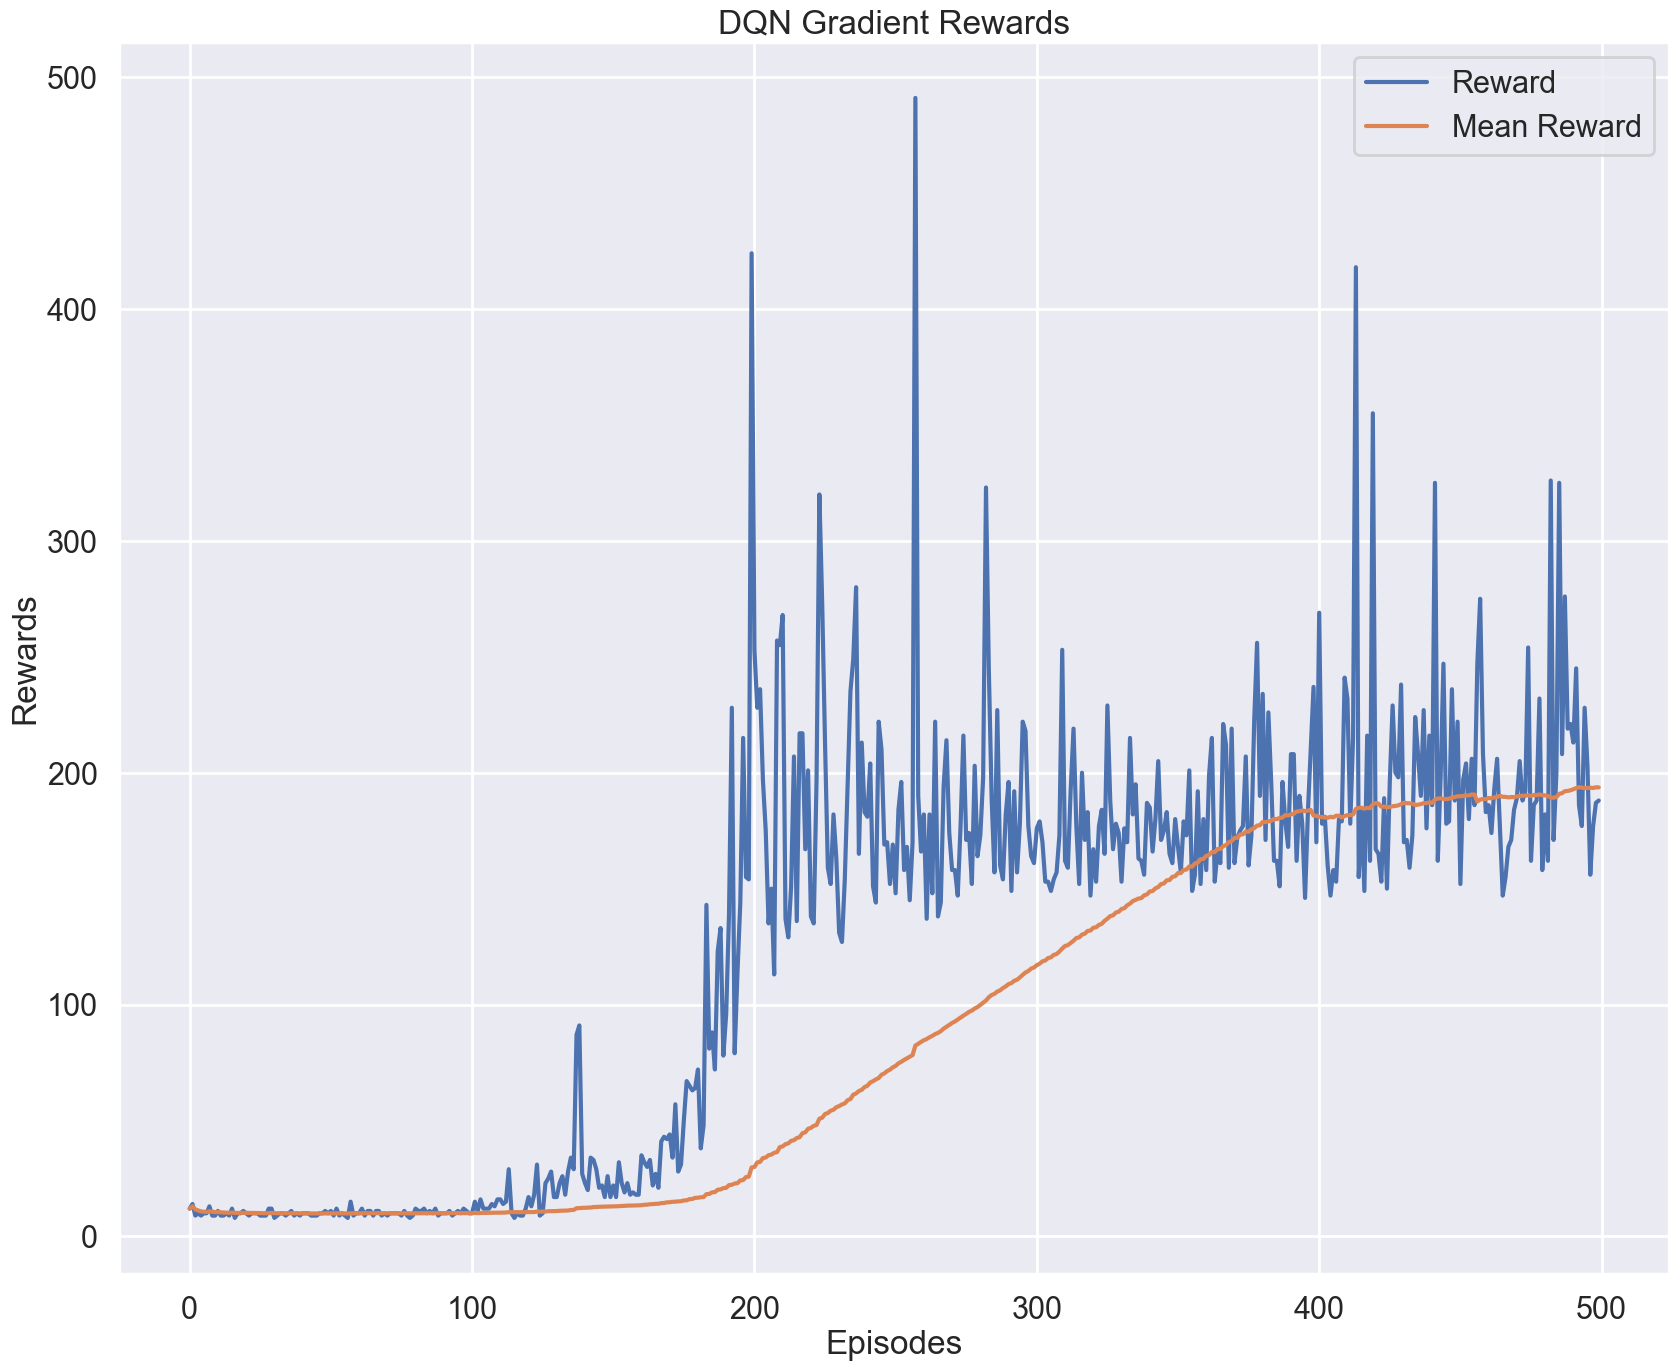

In [13]:
if __name__ == "__main__":
    main()